In [1]:
import pandas as pd 
import numpy as np 

file = 'videotranscript.csv'
data = pd.read_csv(file)

data.head()

,Unnamed: 0,sentence,label
0,0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,sentence
1,1,"Born and raised in Houston, Texas, she perform...",sentence
2,2,"Managed by her father, Mathew Knowles, the gro...",sentence
3,3,Their hiatus saw the release of Beyoncé's debu...,sentence
4,4,Following the disbandment of Destiny's Child i...,sentence


In [2]:
from sklearn.preprocessing import LabelEncoder

# Remove unnecessary index column
data.drop(columns=data.columns[0], inplace=True)

# Clean text: lowercasing, removing punctuation, and stripping whitespace
data['sentence'] = data['sentence'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.strip()

# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

print(data.head())
print(data.shape)

                                            sentence  label
0  beyoncé giselle knowlescarter biːˈjɒnseɪ beeyo...      1
1  born and raised in houston texas she performed...      1
2  managed by her father mathew knowles the group...      1
3  their hiatus saw the release of beyoncés debut...      1
4  following the disbandment of destinys child in...      1
(235110, 2)


In [18]:
import joblib

# Save the LabelEncoder to a file
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  

# Fit and transform the sentences to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(data['sentence'])


print(tfidf_matrix.shape)
print(tfidf_vectorizer.get_feature_names_out()[:100]) 

(235110, 10000)
['01' '02' '03' '05' '10' '100' '1000' '10000' '100000' '101930suser17'
 '1019adultsuser28' '1019adultsuser32' '1019adultsuser35' '102' '105'
 '106' '107' '10th' '11' '110' '1100' '1106adultsuser105' '110820suser21'
 '110840suser18' '110840suser7' '110920suser156' '110940suser18'
 '110940suser34' '110940suser52' '110940suser7' '114' '115' '11th' '12'
 '120' '1200' '12000' '125' '127' '128' '12th' '13' '130' '1300' '13th'
 '14' '1400' '1419teens' '1492' '14th' '15' '150' '1500' '15000' '150000'
 '15th' '16' '160' '1600' '1648' '16th' '17' '1700' '1700s' '1757' '1758'
 '1762' '1776' '1788' '1789' '1790' '1791' '1793' '1795' '17th' '18' '180'
 '1800' '1800s' '1801' '1808' '1810' '1812' '1814' '1815' '1817' '1820'
 '1821' '1822' '1824' '1825' '1829' '1830' '1831' '1832' '1833' '1834'
 '1835' '1836' '1837']


In [4]:
from sklearn.decomposition import TruncatedSVD

# Initialize Truncated SVD with a specific number of components to reduce the feature space
lsa = TruncatedSVD(n_components=300)  

# Fit and transform the TF-IDF matrix using LSA
lsa_matrix = lsa.fit_transform(tfidf_matrix)

# Display the shape of the resulting LSA matrix and the amount of variance explained by the components
print(lsa_matrix.shape)
print(f"Explained variance ratio (cumulative): {sum(lsa.explained_variance_ratio_)}")


(235110, 300)
Explained variance ratio (cumulative): 0.29080739044987475


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Convert TF-IDF to a term-frequency matrix
tf_vectorizer = CountVectorizer(max_features=10000)
tf_matrix = tf_vectorizer.fit_transform(data['sentence'])


lda = LatentDirichletAllocation(n_components=10, random_state=0)  


lda_matrix = lda.fit_transform(tf_matrix)


print(lda_matrix.shape)


(235110, 10)


In [6]:
from gensim.models import Word2Vec
import gensim.downloader as api
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Tokenize sentences
data['tokenized'] = data['sentence'].apply(word_tokenize)

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=data['tokenized'], vector_size=100, window=5, min_count=5, workers=4)

print(word2vec_model.wv.most_similar('example'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stormbreaker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('instance', 0.7486647963523865), ('ideal', 0.6622704267501831), ('explanation', 0.6369928121566772), ('amalgamation', 0.6254404187202454), ('expression', 0.6167770624160767), ('substitute', 0.6009918451309204), ('unknown', 0.595906674861908), ('alloy', 0.5931105017662048), ('abbreviation', 0.5892019867897034), ('jew', 0.5867902040481567)]


In [8]:

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')


sentence_embeddings = model.encode(data['sentence'].tolist())


print(sentence_embeddings.shape)


c:\Users\stormbreaker\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(235110, 384)


AUC Score: 0.9529620931625967


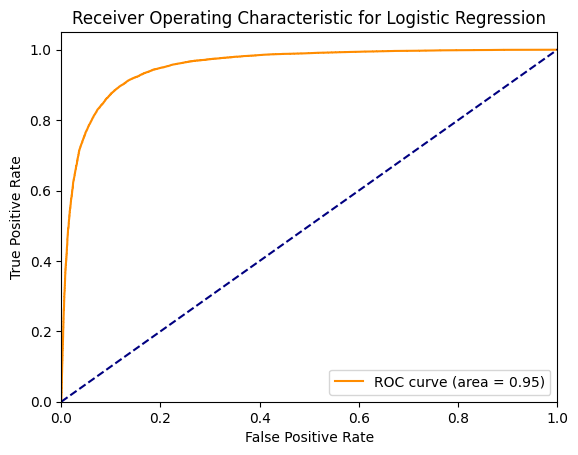

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, data['label'], test_size=0.2, random_state=42)


lr_model = LogisticRegression(max_iter=1000)


lr_model.fit(X_train, y_train)


y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()


SVM AUC Score: 0.8732579490998759


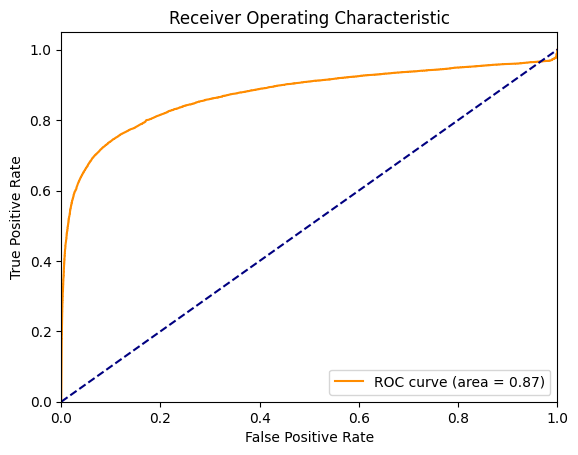

In [23]:
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))


svm_model.fit(X_train, y_train)


y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]


auc_score_svm = roc_auc_score(y_test, y_pred_proba_svm)
print("SVM AUC Score:", auc_score_svm)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_svm)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_score_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Random Forest AUC Score: 0.9843300259338836


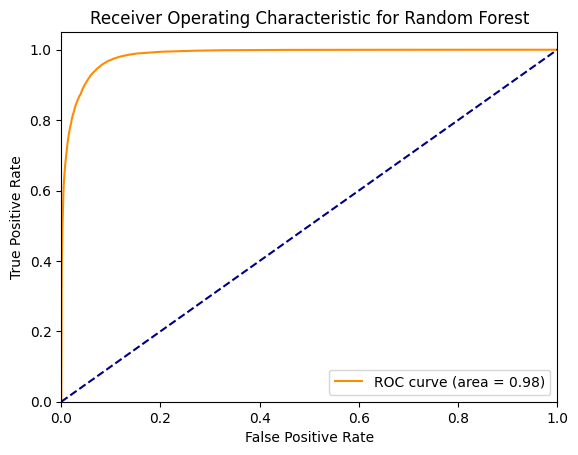

['scaler.pkl']

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assume you have already loaded your data into a DataFrame 'data'
# and you have prepared your features into 'X' and labels into 'y'

# Sample data loading (you'll replace this with your actual data loading code)
# data = pd.read_csv('your_data.csv')
# X = data.drop('target_column', axis=1).values  # Features
# y = data['target_column'].values  # Target labels

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally standardize the data if needed
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict probabilities for the test data
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Random Forest AUC Score: {auc_score}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest')
plt.legend(loc="lower right")
plt.show()


joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


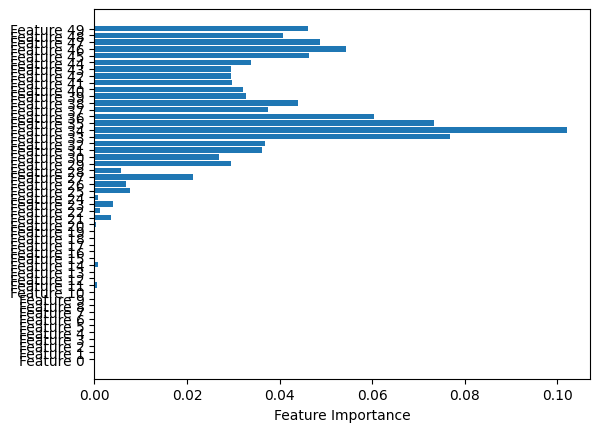

In [30]:
importances = rf_model.feature_importances_
# Plot feature importances
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), [f"Feature {i}" for i in range(len(importances))])
plt.xlabel("Feature Importance")
plt.show()


In [31]:
from sklearn.metrics import classification_report
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.95      0.94     26418
           1       0.93      0.92      0.92     20604

    accuracy                           0.93     47022
   macro avg       0.93      0.93      0.93     47022
weighted avg       0.93      0.93      0.93     47022



In [32]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Parameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated AUC:", grid_search.best_score_)

# Use the best model
best_rf_model = grid_search.best_estimator_


Epoch 1/10
2939/2939 [==============================] - 5s 1ms/step - loss: 0.3865 - accuracy: 0.8328 - val_loss: 0.3654 - val_accuracy: 0.8388
Epoch 2/10
2939/2939 [==============================] - 4s 2ms/step - loss: 0.3546 - accuracy: 0.8498 - val_loss: 0.3539 - val_accuracy: 0.8490
Epoch 3/10
2939/2939 [==============================] - 4s 1ms/step - loss: 0.3468 - accuracy: 0.8533 - val_loss: 0.3494 - val_accuracy: 0.8518
Epoch 4/10
2939/2939 [==============================] - 4s 1ms/step - loss: 0.3430 - accuracy: 0.8560 - val_loss: 0.3602 - val_accuracy: 0.8429
Epoch 5/10
2939/2939 [==============================] - 4s 1ms/step - loss: 0.3406 - accuracy: 0.8568 - val_loss: 0.3449 - val_accuracy: 0.8566
Epoch 6/10
2939/2939 [==============================] - 4s 1ms/step - loss: 0.3383 - accuracy: 0.8580 - val_loss: 0.3474 - val_accuracy: 0.8573
Epoch 7/10
2939/2939 [==============================] - 4s 1ms/step - loss: 0.3366 - accuracy: 0.8593 - val_loss: 0.3407 - val_accuracy:

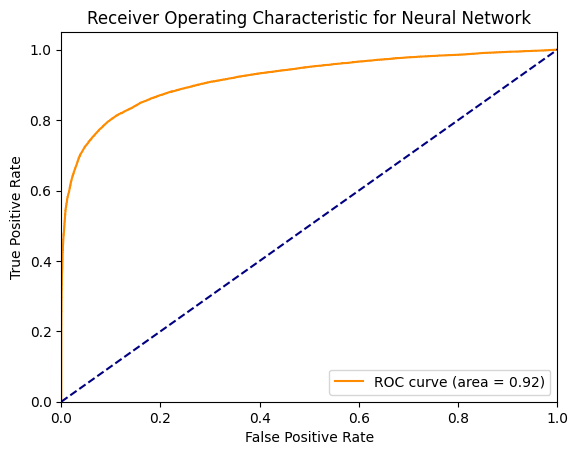

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Sample data loading and preprocessing steps
# Ensure your dataset 'data' is loaded, for example via:
# data = pd.read_csv('path_to_your_data.csv')

# Example features and labels extraction if 'X' and 'y' are not predefined
# X = data.drop(['label_column'], axis=1).values
# y = data['label_column'].values

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Building the Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predict probabilities for the test data
y_pred_probs = model.predict(X_test).flatten()

# Calculate the ROC AUC score
auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"Neural Network AUC Score: {auc_score}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Neural Network')
plt.legend(loc="lower right")
plt.show()
